In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [83]:
data = pd.read_csv('archive/DataCoSupplyChainDataset.csv', encoding='latin1')
data.tail()

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
180514,CASH,4,4,40.000000,399.980011,Shipping on time,0,45,Fishing,Brooklyn,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 3:40,Standard Class
180515,DEBIT,3,2,-613.770019,395.980011,Late delivery,1,45,Fishing,Bakersfield,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 1:34,Second Class
180516,TRANSFER,5,4,141.110001,391.980011,Late delivery,1,45,Fishing,Bristol,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/20/2016 21:00,Standard Class
180517,PAYMENT,3,4,186.229996,387.980011,Advance shipping,0,45,Fishing,Caguas,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/18/2016 20:18,Standard Class
180518,PAYMENT,4,4,168.949997,383.980011,Shipping on time,0,45,Fishing,Caguas,...,NaN,1004,45,NaN,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,1/19/2016 18:54,Standard Class


In [84]:
# Dropping heavily sensitive/ppintless cols
cols_to_drop = [
    'customer_email', 'customer_password', 'customer_fname',
    'product_image', 'product_description', 'product_status'
]
data = data.drop(columns=[c for c in cols_to_drop if c in data.columns])

In [85]:
required_columns = [
        'Days for shipping (real)',
        'Days for shipment (scheduled)',
        'Shipping Mode',
        'Order Status',
        'Order Region',
        'Delivery Status',
        'Order State',
        'Order Item Quantity',
        'Order Item Discount Rate',
        'Order Item Profit Ratio',
        'Product Price',
        'Category Name',
        'shipping date (DateOrders)',
        'Late_delivery_risk'
]

In [86]:
new_data = data[required_columns].to_csv('new_data.csv', index=False)

In [87]:
data_final = pd.read_csv('new_data.csv')
data_final.head()

,Days for shipping (real),Days for shipment (scheduled),Shipping Mode,Order Status,Order Region,Delivery Status,Order State,Order Item Quantity,Order Item Discount Rate,Order Item Profit Ratio,Product Price,Category Name,shipping date (DateOrders),Late_delivery_risk
0,3,4,Standard Class,COMPLETE,Southeast Asia,Advance shipping,Java Occidental,1,0.04,0.29,327.75,Sporting Goods,2/3/2018 22:56,0
1,5,4,Standard Class,PENDING,South Asia,Late delivery,Rajastán,1,0.05,-0.80,327.75,Sporting Goods,1/18/2018 12:27,1
2,4,4,Standard Class,CLOSED,South Asia,Shipping on time,Rajastán,1,0.06,-0.80,327.75,Sporting Goods,1/17/2018 12:06,0
3,3,4,Standard Class,COMPLETE,Oceania,Advance shipping,Queensland,1,0.07,0.08,327.75,Sporting Goods,1/16/2018 11:45,0
4,2,4,Standard Class,PENDING_PAYMENT,Oceania,Advance shipping,Queensland,1,0.09,0.45,327.75,Sporting Goods,1/15/2018 11:24,0


### Focusing on pre-shipment features only

To avoid information leakage, we drop columns that reveal actual shipping outcomes (e.g., `Days for shipping (real)`, `Delivery Status`, and the actual `shipping date`). This keeps the modelling features restricted to data that would be known when the order is created or scheduled.

In [88]:
leakage_features = [
    'Days for shipping (real)',
    'Delivery Status',
    'shipping date (DateOrders)'
]

model_ready_cols = [col for col in data_final.columns if col not in leakage_features]
data_model_ready = data_final[model_ready_cols].copy()

print("Columns used for modelling (post-leakage filter):")
print(data_model_ready.columns.tolist())
print("\nShape:", data_model_ready.shape)

Columns used for modelling (post-leakage filter):
['Days for shipment (scheduled)', 'Shipping Mode', 'Order Status', 'Order Region', 'Order State', 'Order Item Quantity', 'Order Item Discount Rate', 'Order Item Profit Ratio', 'Product Price', 'Category Name', 'Late_delivery_risk']

Shape: (180519, 11)


### Statistical characteristics & missingness snapshot
Using the pre-shipment feature set `data_model_ready`, we report descriptive statistics for all numeric variables and the percentage of missing values per column, as required by the project spec.

In [89]:
numeric_cols = data_model_ready.select_dtypes(include=[np.number]).columns.tolist()

if numeric_cols:
    summary_table = (
        data_model_ready[numeric_cols]
        .describe(percentiles=[0.25, 0.5, 0.75])
        .T
        .assign(
            missing_pct=(
                100 * (1 - data_model_ready[numeric_cols].count() / len(data_model_ready))
            ).round(2)
        )
    )
    print("Numeric feature summary (rows = features):")
    display(summary_table.round(2))
else:
    print("No numeric columns found for summary stats.")

missing_pct = (data_model_ready.isna().mean() * 100).round(2).sort_values(ascending=False)
print("\nMissingness percentages (all columns):")
display(missing_pct)

Numeric feature summary (rows = features):


,count,mean,std,min,25%,50%,75%,max,missing_pct
Days for shipment (scheduled),180519.0,2.93,1.37,0.00,2.00,4.00,4.00,4.00,0.0
Order Item Quantity,180519.0,2.13,1.45,1.00,1.00,1.00,3.00,5.00,0.0
Order Item Discount Rate,180519.0,0.10,0.07,0.00,0.04,0.10,0.16,0.25,0.0
Order Item Profit Ratio,180519.0,0.12,0.47,-2.75,0.08,0.27,0.36,0.50,0.0
Product Price,180519.0,141.23,139.73,9.99,50.00,59.99,199.99,1999.99,0.0
Late_delivery_risk,180519.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00,0.0



Missingness percentages (all columns):


Days for shipment (scheduled)    0.0
Shipping Mode                    0.0
Order Status                     0.0
Order Region                     0.0
Order State                      0.0
Order Item Quantity              0.0
Order Item Discount Rate         0.0
Order Item Profit Ratio          0.0
Product Price                    0.0
Category Name                    0.0
Late_delivery_risk               0.0
dtype: float64

DATA PREPROCESSING

In [90]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Days for shipping (real)       180519 non-null  int64  
 1   Days for shipment (scheduled)  180519 non-null  int64  
 2   Shipping Mode                  180519 non-null  object 
 3   Order Status                   180519 non-null  object 
 4   Order Region                   180519 non-null  object 
 5   Delivery Status                180519 non-null  object 
 6   Order State                    180519 non-null  object 
 7   Order Item Quantity            180519 non-null  int64  
 8   Order Item Discount Rate       180519 non-null  float64
 9   Order Item Profit Ratio        180519 non-null  float64
 10  Product Price                  180519 non-null  float64
 11  Category Name                  180519 non-null  object 
 12  shipping date (DateOrders)    

In [91]:
data_final.isnull().sum()

Days for shipping (real)         0
Days for shipment (scheduled)    0
Shipping Mode                    0
Order Status                     0
Order Region                     0
Delivery Status                  0
Order State                      0
Order Item Quantity              0
Order Item Discount Rate         0
Order Item Profit Ratio          0
Product Price                    0
Category Name                    0
shipping date (DateOrders)       0
Late_delivery_risk               0
dtype: int64

There are no Missing values

In [92]:
data_final.dtypes

Days for shipping (real)           int64
Days for shipment (scheduled)      int64
Shipping Mode                     object
Order Status                      object
Order Region                      object
Delivery Status                   object
Order State                       object
Order Item Quantity                int64
Order Item Discount Rate         float64
Order Item Profit Ratio          float64
Product Price                    float64
Category Name                     object
shipping date (DateOrders)        object
Late_delivery_risk                 int64
dtype: object

EDA

In [93]:
data_final['Late_delivery_risk'].value_counts()

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

1 --> Late
0 --> On-time

Delay Rate must be the mean of two

In [94]:
delay_rate = data_final['Late_delivery_risk'].mean()
print(delay_rate)

0.5482913155955883


It tells us that about 55% of all the orders had a late delivery and 45% were on time

In [95]:
data_final.describe()

,Days for shipping (real),Days for shipment (scheduled),Order Item Quantity,Order Item Discount Rate,Order Item Profit Ratio,Product Price,Late_delivery_risk
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000
mean,3.497654,2.931847,2.127638,0.101668,0.120647,141.232550,0.548291
std,1.623722,1.374449,1.453451,0.070415,0.466796,139.732492,0.497664
min,0.000000,0.000000,1.000000,0.000000,-2.750000,9.990000,0.000000
25%,2.000000,2.000000,1.000000,0.040000,0.080000,50.000000,0.000000
50%,3.000000,4.000000,1.000000,0.100000,0.270000,59.990002,1.000000
75%,5.000000,4.000000,3.000000,0.160000,0.360000,199.990005,1.000000
max,6.000000,4.000000,5.000000,0.250000,0.500000,1999.989990,1.000000


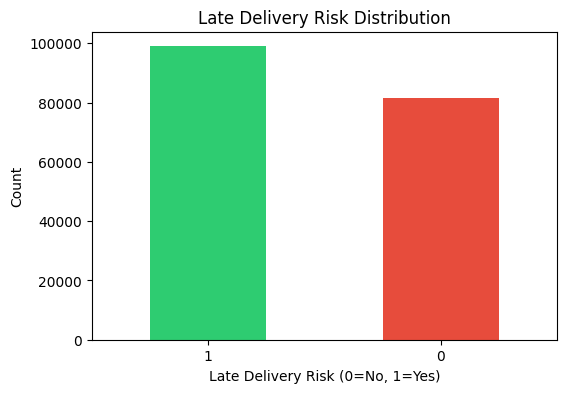

In [96]:
plt.figure(figsize=(6, 4))
data_final['Late_delivery_risk'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c'])
plt.title('Late Delivery Risk Distribution')
plt.xlabel('Late Delivery Risk (0=No, 1=Yes)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


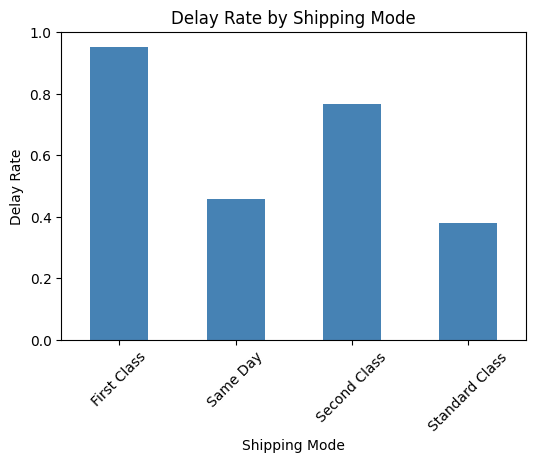

In [97]:
plt.figure(figsize=(6, 4))
shipping_analysis = data_final.groupby('Shipping Mode')['Late_delivery_risk'].mean()
shipping_analysis.plot(kind='bar', color='steelblue')
plt.title('Delay Rate by Shipping Mode')
plt.ylabel('Delay Rate')
plt.xticks(rotation=45)
plt.show()


ALTHOUGH THE FIRST CLASS MUST HAVE VERY LESS DELAY BUT OVER HERE THERE IS HIGH DELAY IN FIRST CLASS COMAPRED TO STANDARD CLASS WHICH IS LESS OUT OF ALL

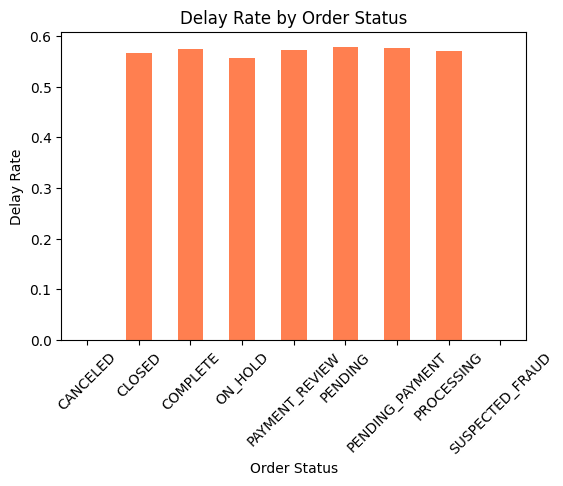

In [98]:
plt.figure(figsize=(6, 4))
status_analysis = data_final.groupby('Order Status')['Late_delivery_risk'].mean()
status_analysis.plot(kind='bar', color='coral')
plt.title('Delay Rate by Order Status')
plt.ylabel('Delay Rate')
plt.xticks(rotation=45)
plt.show()


DELAYS ARE VERY HIGH FOR ALMOST ALL  THE ORDER STATUSES

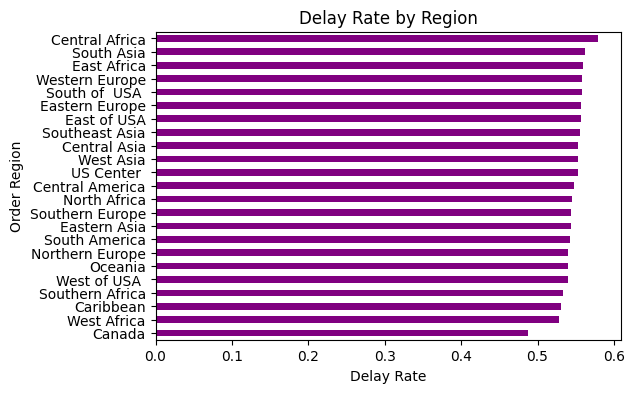

In [99]:
plt.figure(figsize=(6, 4))
region_analysis = data_final.groupby('Order Region')['Late_delivery_risk'].mean().sort_values()
region_analysis.plot(kind='barh', color='purple')
plt.title('Delay Rate by Region')
plt.xlabel('Delay Rate')
plt.show()


VERY REGIONS HAVE SIGNIFICANT DELAYS GREATER THAN 49% DELAYS IN EVERY REGIONS.

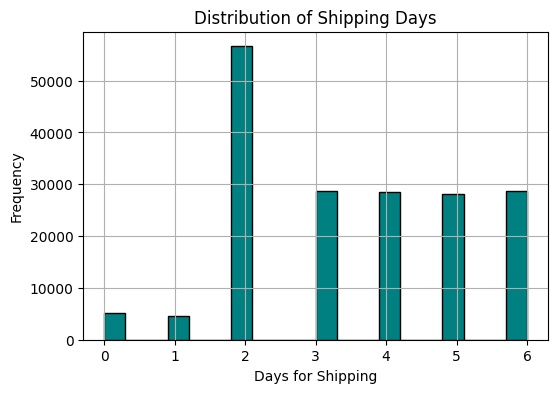

In [100]:
plt.figure(figsize=(6, 4))
data_final['Days for shipping (real)'].hist(bins=20, color='teal', edgecolor='black')
plt.title('Distribution of Shipping Days')
plt.xlabel('Days for Shipping')
plt.ylabel('Frequency')
plt.show()


WE CAN OBSERVE THAT MAJORITY OF ORDERS ARE SHIPPED IN 2 DAYS
SHIPPING TIMES CLUSTER AROUND @ to 6 DAYS WITH MUCH FEWER ORDERS SHIPPED IN 0 or 1 DAY.

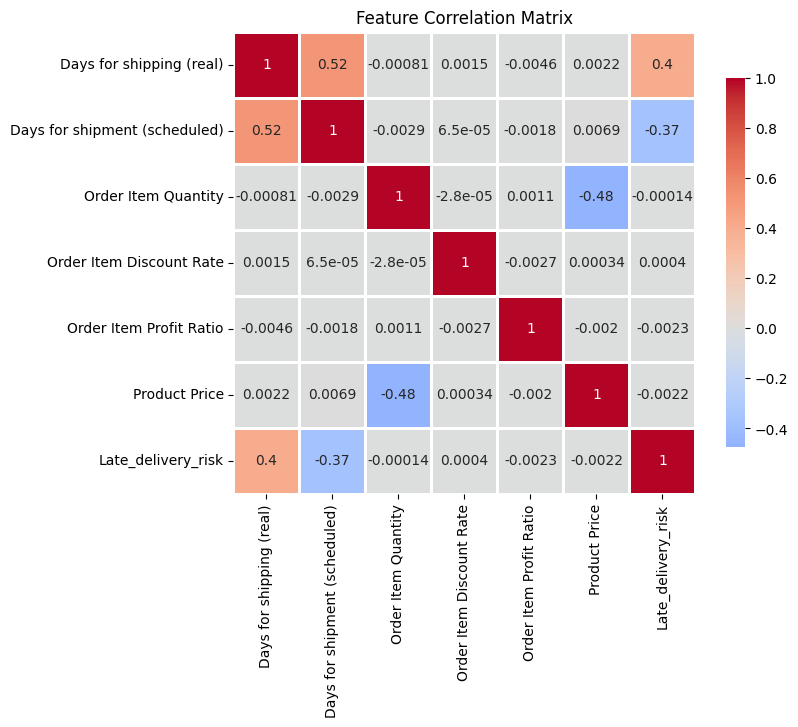

In [101]:
plt.figure(figsize=(8, 6))
numeric_cols = data_final.select_dtypes(include='number').columns
corr_matrix = data_final[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.show()


DAYS FOR SHIPPING(REAL) AND LATE_DELIVERY_RISK HAVE A STRONG CORRELEATION
DAYS FOR SHIPMENT(SCHEDULED) CORRELATES NEGATIVELY WITH THE RISK SUGGESTING THAT ORDERS SCHEDULED FOR LONGER SHIPPING TIME ARE LESS LIKELY TO BE LATE.
OTHERS HAVE VERY LESS OR NO CORRELATION WITHT HE TARGET

**FEATURE ENGINEERING**

In [102]:
data = data_model_ready.copy()

In [103]:
label_encoders = {}
categorical_cols = data.select_dtypes(include=['object']).columns
categorical_cols

Index(['Shipping Mode', 'Order Status', 'Order Region', 'Order State',
       'Category Name'],
      dtype='object')

In [104]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
for col in categorical_cols:
  if col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le


In [105]:
if 'Days for shipping (real)' in data and 'Days for shipment (scheduled)':
  data['Shipping_efficiency'] = data['Days for shipment (scheduled)'] / data['Days for shipping (real)']

In [106]:
if 'Product Price' in data.columns:
    data['Price_category'] = pd.cut(data['Product Price'],
                                      bins=[0, 100, 300, 500, float('inf')],
                                      labels=[0, 1, 2, 3])


In [107]:
if 'Order Item Discount Rate' in data.columns:
    data['High_discount_rate'] = (data['Order Item Discount Rate'] > data['Order Item Discount Rate'].median()).astype(int)



In [108]:
data.tail()

,Days for shipment (scheduled),Shipping Mode,Order Status,Order Region,Order State,Order Item Quantity,Order Item Discount Rate,Order Item Profit Ratio,Product Price,Category Name,Late_delivery_risk,Price_category,High_discount_rate
180514,4,3,1,7,913,1,0.00,0.10,399.980011,18,0,2,0
180515,2,2,2,7,770,1,0.01,-1.55,399.980011,18,1,2,0
180516,4,3,5,11,88,1,0.02,0.36,399.980011,18,1,2,0
180517,4,3,6,11,88,1,0.03,0.48,399.980011,18,0,2,0
180518,4,3,6,13,967,1,0.04,0.44,399.980011,18,0,2,0


In [109]:
X = data.drop('Late_delivery_risk', axis=1)
y = data['Late_delivery_risk']


In [110]:
y.value_counts()

Late_delivery_risk
1    98977
0    81542
Name: count, dtype: int64

In [111]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [112]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify = y)


In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve)


In [115]:
import numpy as np
from sklearn.linear_model import LogisticRegression


X_train_scaled_cleaned = np.nan_to_num(X_train_scaled)
X_test_scaled_cleaned = np.nan_to_num(X_test_scaled)

model_lr = LogisticRegression()
model_lr.fit(X_train_scaled_cleaned, y_train)
y_pred_lr = model_lr.predict(X_test_scaled_cleaned)

In [116]:
y_pred_train = model_lr.predict(X_train_scaled_cleaned)
train_accuracy = accuracy_score(y_train,y_pred_train)
print(train_accuracy)

0.6901545547351677


In [117]:
accuracy = accuracy_score(y_test, y_pred_lr)
print("Accuracy:", accuracy)

Accuracy: 0.691945490804343


In [118]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix:\n", cm_lr)

Confusion Matrix:
 [[20028  4435]
 [12248 17445]]


TOP LEFT --> TN- On-time deliveries correctly predicted

TOP RIGHT --> FP - ON-Time incorrectly predicited as late.

BOTTOM LEFT --> FN - Late deliveries incorrectly predicted as on-time

BOTTOM RIGHT --> TP - late deliverires correctly predicted


In [119]:
cv_scores = cross_val_score(model_lr, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)


Cross-validation scores: [0.65615479 0.66561152 0.65955763 0.65736784 0.6624723 ]


In [ ]:
# Random Forest model: train and evaluate on the same split
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)


rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)

rf_cm = confusion_matrix(y_test, y_pred_rf)
print("Random Forest Confusion Matrix:\n", rf_cm)

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.6976142994312726
Random Forest Confusion Matrix:
 [[18547  5916]
 [10460 19233]]

Classification report (Random Forest):
              precision    recall  f1-score   support

           0       0.64      0.76      0.69     24463
           1       0.76      0.65      0.70     29693

    accuracy                           0.70     54156
   macro avg       0.70      0.70      0.70     54156
weighted avg       0.71      0.70      0.70     54156

